In [16]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings('ignore')

In [18]:
def load_data(filepath):
    df = pd.read_csv(filepath)
    
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    
    df.sort_index(inplace=True)
    
    return df

raw_data = load_data('ETHUSDT.csv')
print(f">> LOAD DATA SUCCESSFULLY. SHAPE: {raw_data.shape}")

raw_data.describe()

>> LOAD DATA SUCCESSFULLY. SHAPE: (100222, 5)


,open,high,low,close,volume
count,100222.000000,100222.000000,100222.000000,100222.000000,1.002220e+05
mean,2020.850894,2028.743724,2012.538468,2020.895240,6.953105e+04
std,1142.978576,1147.338935,1138.329111,1142.993254,8.654758e+04
min,95.730000,98.440000,84.230000,95.730000,0.000000e+00
25%,1293.550000,1298.292500,1288.550000,1293.560000,2.393219e+04
50%,1909.370000,1915.320000,1902.850000,1909.395000,4.340188e+04
75%,2905.067500,2916.990000,2890.315000,2905.132500,8.126771e+04
max,4852.000000,4877.540000,4843.580000,4852.080000,1.915609e+06


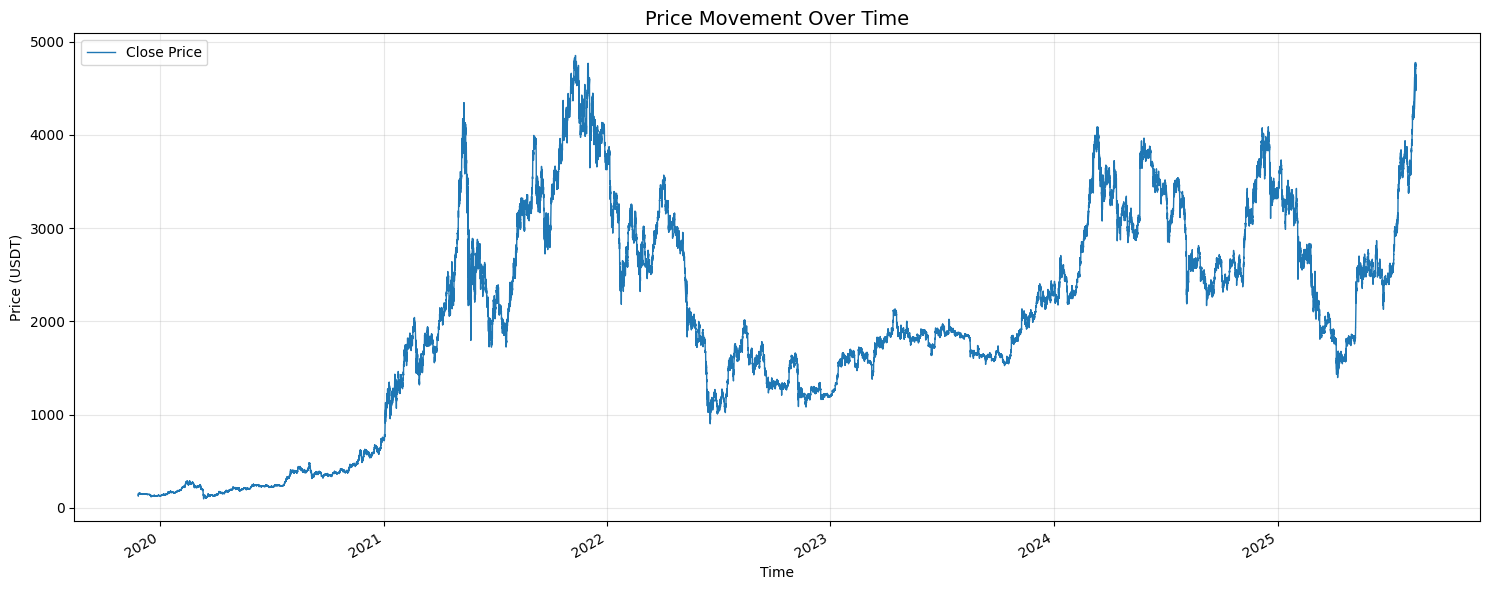

In [19]:
def plot_raw_data(df):
    fig, ax = plt.subplots(figsize=(15, 6)) 
    
    ax.plot(df.index, df['close'], label='Close Price', linewidth=1)
    
    ax.set_title('Price Movement Over Time', fontsize=14)
    ax.set_ylabel('Price (USDT)')
    ax.set_xlabel('Time')
    
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


plot_raw_data(raw_data)


### Technical Feature Definitions

- **Log Return**: Logarithmic price return between two consecutive close prices.

- **SMA 20 / SMA 50**: Simple moving averages of the close price over 20 and 50 periods.

- **Distance to SMA (20, 50)**: Normalized deviation of the close price from its moving average.

- **MACD**: Difference between 12-period and 26-period exponential moving averages.

- **MACD Signal / Histogram**: Exponential moving average of MACD and its residual.

- **RSI**: Momentum oscillator computed from exponentially smoothed gains and losses.

- **Rolling Volatility**: Rolling standard deviation of log returns over a fixed window.

- **Bollinger Bands (Upper, Lower)**: Upper and lower bands defined by SMA ± k standard deviations.

- **Bollinger Band Width**: Relative distance between upper and lower Bollinger Bands.

- **High-Low Range**: Normalized intraperiod price range.

- **Volume Ratio**: Ratio of current volume to its rolling average.


In [20]:
def add_technical_features(df):
    data = df.copy()

    # Log return
    data['Log_Ret'] = np.log(data['close'] / data['close'].shift(1))
    
    # SMA (Simple Moving Average)
    data['SMA_20'] = data['close'].rolling(window=20).mean()
    data['SMA_50'] = data['close'].rolling(window=50).mean()
    
    # Distance to SMA 
    data['Dist_SMA20'] = (data['close'] - data['SMA_20']) / data['SMA_20']
    data['Dist_SMA50'] = (data['close'] - data['SMA_50']) / data['SMA_50']
    
    # MACD (Moving Average Convergence Divergence)
    ema_12 = data['close'].ewm(span=12, adjust=False).mean()
    ema_26 = data['close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = ema_12 - ema_26
    # Signal Line
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    # MACD Histogram
    data['MACD_Hist'] = data['MACD'] - data['MACD_Signal']

    # RSI (Relative Strength Index) 
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))
    
    avg_gain = gain.ewm(alpha=1/14, min_periods=14, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/14, min_periods=14, adjust=False).mean()
    
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # Rolling Volatility
    data['Volatility'] = data['Log_Ret'].rolling(window=20).std()
    
    # Bollinger Bands
    # Middle Band = SMA 20
    bb_middle = data['close'].rolling(window=20).mean()
    # Std Dev
    bb_std = data['close'].rolling(window=20).std()
    
    data['BB_Upper'] = bb_middle + (2 * bb_std)
    data['BB_Lower'] = bb_middle - (2 * bb_std)
    
    # BB Width
    data['BB_Width'] = (data['BB_Upper'] - data['BB_Lower']) / bb_middle
    
    # High-Low Range
    data['HL_Range'] = (data['high'] - data['low']) / data['close']

    # Volume Ratio
    vol_ma20 = data['volume'].rolling(window=20).mean()
    data['Vol_Ratio'] = data['volume'] / (vol_ma20 + 1e-9) 

    data.dropna(inplace=True)
    
    return data

### Time-based Feature Encoding

- **hour_sin / hour_cos**: Cyclical encoding of intraday time, capturing periodic patterns within a 24-hour trading day.

- **dayofweek_sin / dayofweek_cos**: Cyclical representation of the day of the week.

- **month_sin / month_cos**: Cyclical encoding of the month of the year.


In [21]:
def add_time_features(df):
    data = df.copy()
    
    minutes_in_day = data.index.hour * 60 + data.index.minute
    
    data['hour_sin'] = np.sin(2 * np.pi * minutes_in_day / 1440)
    data['hour_cos'] = np.cos(2 * np.pi * minutes_in_day / 1440)
    

    data['dayofweek_sin'] = np.sin(2 * np.pi * data.index.dayofweek / 7)
    data['dayofweek_cos'] = np.cos(2 * np.pi * data.index.dayofweek / 7)
    
    month_adj = data.index.month - 1 
    data['month_sin'] = np.sin(2 * np.pi * month_adj / 12)
    data['month_cos'] = np.cos(2 * np.pi * month_adj / 12)
    
    return data

### Target Construction

Technical and time-based features are constructed exclusively from historical OHLCV data to avoid look-ahead bias.

The prediction target is defined as a binary variable indicating whether the next-period close price exceeds the current close by a fixed threshold (0.15%). Then the problem changes to binary classification


In [22]:
def prepare_data(raw_data, threshold=0.0015):
    processed_data = add_technical_features(raw_data)
    processed_data = add_time_features(processed_data)
    processed_data.dropna(inplace=True)

    # Compute one-step-ahead future return proxy
    future_close = processed_data['close'].shift(-1)
    current_close = processed_data['close']

    # Binary target: 1 if next-period close exceeds current close by the threshold, else 0
    processed_data['target'] = np.where(future_close > current_close * (1 + threshold), 1, 0)

    final_data = processed_data.iloc[:-1].copy()
    return final_data

final_data = prepare_data(raw_data, threshold=0.0015)

In [23]:
feature_cols = [
    # Technical Features
    'Log_Ret',
    'Dist_SMA20',
    'Dist_SMA50',
    'RSI',
    'MACD_Hist',
    'Volatility',
    'BB_Width',
    'HL_Range',
    'Vol_Ratio',
    # Time Encoding
    'hour_sin', 'hour_cos',
    'dayofweek_sin', 'dayofweek_cos',
    'month_sin', 'month_cos'
    ]

def define_X_and_y(final_data, feature_cols):
    X = final_data[feature_cols]
    y = final_data['target']

    return X, y

X, y = define_X_and_y(final_data, feature_cols)

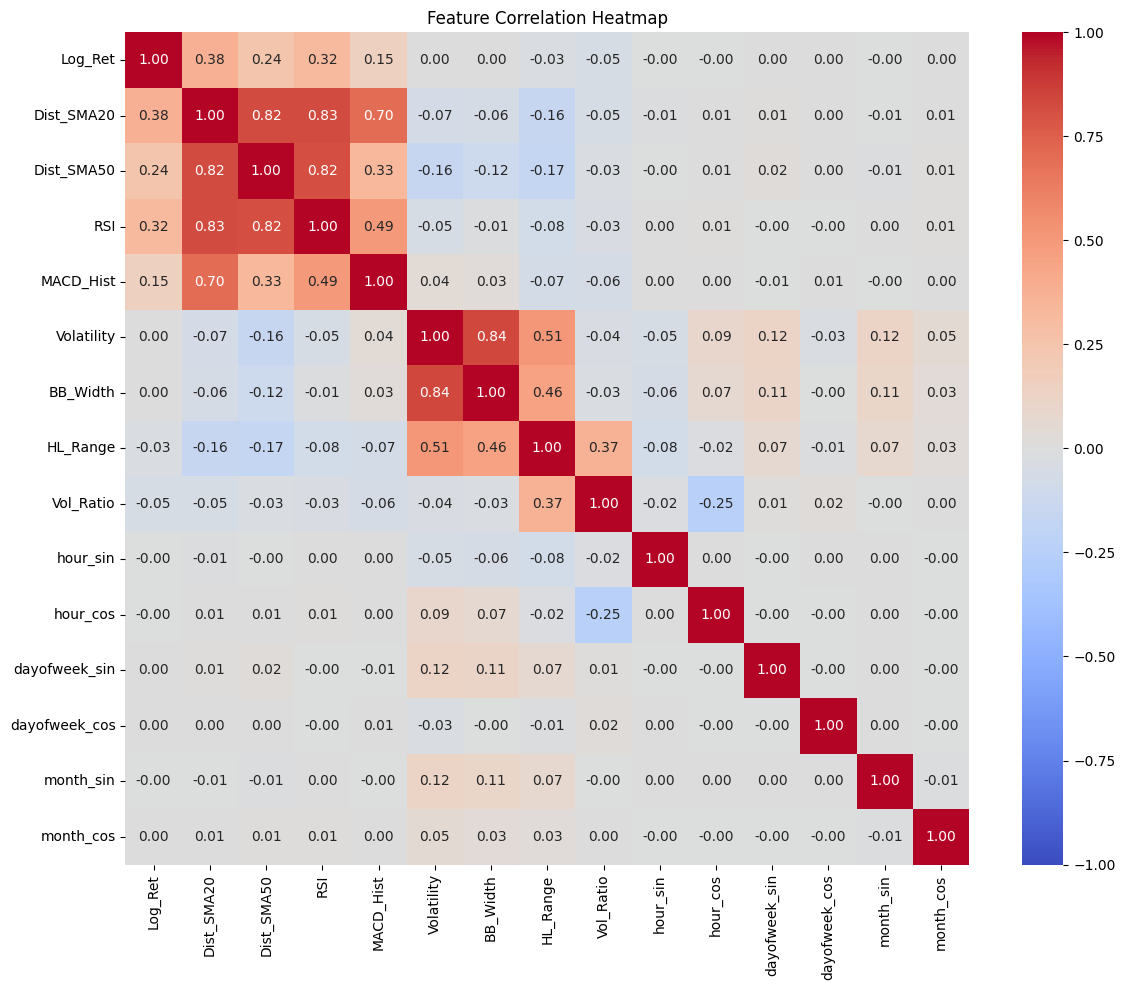

In [24]:
def plot_correlation_heatmap(df, features):
    plt.figure(figsize=(12, 10))
    
    corr_matrix = df[features].corr()
    
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()

plot_correlation_heatmap(final_data, feature_cols)

### Performance Evaluation
- **Cumulative Return:** measures the total compounded return over the backtesting period.
- **Annualized Sharpe Ratio:** evaluates risk-adjusted performance by scaling the mean return over its standard deviation to an annual frequency.
- **Maximum Drawdown:** captures the worst peak-to-trough loss experienced by the strategy.
- **Win Rate:** represents the proportion of profitable trades among all executed trades.




In [25]:
def calculate_metrics(signals, returns):
    
    # Cumulative Return
    strat_ret = signals * returns
    total_return = np.prod(1 + strat_ret) - 1
    
    # Sharpe Ratio (Annualized)
    sharpe = 0
    if strat_ret.std() > 0:
        sharpe = (strat_ret.mean() / strat_ret.std()) * np.sqrt(365 * 48) 
        
    # Max Drawdown
    cum = (1 + strat_ret).cumprod()
    max_dd = ((cum - cum.cummax()) / cum.cummax()).min()
    
    # Win Rate
    winning_trades = len(strat_ret[strat_ret > 0])
    total_trades = len(strat_ret[strat_ret != 0])
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
        
    return total_return, sharpe, max_dd, win_rate


### Trading Logic

- Enter **Long** when predicted probability of an upward move exceeds 0.60 and price is above the 50-period moving average.
- Enter **Short** when predicted probability falls below 0.40 and price is below the 50-period moving average.
- Remain **Flat** when no condition is satisfied to avoid low-confidence signals.

---

### Backtesting Mechanism

- Use time-series cross-validation, split into 5 folds with gap = 5 to preserve chronological order and avoid information leakage.
- Generate trading signals strictly from out-of-sample predictions.
- Apply signals to next-period returns to simulate realistic trade execution.


In [26]:
models = {
    "LightGBM": LGBMClassifier(
        n_estimators=100, learning_rate=0.05, max_depth=6,
        random_state=42, n_jobs=-1, verbose=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100, learning_rate=0.05, max_depth=6,
        eval_metric='logloss', random_state=42, n_jobs=-1
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, min_samples_leaf=20,
        random_state=42, n_jobs=-1
    )
}

def run_backtest(X, y, final_data, models, threshold_long=0.60, threshold_short=0.40, n_splits=5, gap=1):
    # Time-series cross-validation with gap to prevent leakage
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap)

    # Containers for results
    results_log = []
    fold_returns_store = {name: [] for name in models.keys()}
    market_returns_store = []

    print(">> STARTING BACKTEST...")

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        print(f"\n>>> FOLD {fold + 1}/{n_splits}:")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        train_start, train_end = X_train.index[0], X_train.index[-1]
        test_start, test_end = X_test.index[0], X_test.index[-1]

        print(f"  + TRAIN: {len(X_train):6d} samples | {train_start} → {train_end}")
        print(f"  + TEST : {len(X_test):6d} samples | {test_start} → {test_end}")

        test_context = final_data.iloc[test_idx]

        # Market returns used for backtesting
        market_ret = test_context['Log_Ret'].shift(-1).fillna(0)
        market_returns_store.append(market_ret)

        for name, model in models.items():
            model.fit(X_train, y_train)

            probs = model.predict_proba(X_test)[:, 1]

            # LONG SIGNAL
            sig_long_ai = np.where(probs > threshold_long, 1, 0)
            trend_long = np.where(test_context['close'] > test_context['SMA_50'], 1, 0)
            final_long = sig_long_ai * trend_long

            # SHORT SIGNAL
            sig_short_ai = np.where(probs < threshold_short, -1, 0)
            trend_short = np.where(test_context['close'] < test_context['SMA_50'], 1, 0)
            final_short = sig_short_ai * trend_short

            # Final trading signal
            final_signal = final_long + final_short

            # Strategy returns
            strat_ret = final_signal * market_ret
            fold_returns_store[name].append(strat_ret)

            # Performance metrics
            ret, sharpe, mdd, win_rate = calculate_metrics(final_signal, market_ret)

            results_log.append({
                'Fold': fold + 1,
                'Model': name,
                'Return': ret,
                'Sharpe': sharpe,
                'MaxDD': mdd,
                'WinRate': win_rate
            })

            print(
                f"  + {name:<15}: Sharpe={sharpe:.2f} | "
                f"Return={ret:.2%} | MaxDD={mdd:.2%}"
            )

    return results_log, fold_returns_store, market_returns_store

results_log, fold_returns_store, market_returns_store = run_backtest(X, y, final_data, models, threshold_long=0.6, threshold_short=0.4, n_splits=5, gap=5)


>> STARTING BACKTEST...

>>> FOLD 1/5:
  + TRAIN:  16692 samples | 2019-11-28 08:00:00 → 2020-11-10 01:30:00
  + TEST :  16695 samples | 2020-11-10 04:30:00 → 2021-10-23 23:30:00
  + LightGBM       : Sharpe=2.17 | Return=146.95% | MaxDD=-30.62%
  + XGBoost        : Sharpe=1.50 | Return=78.18% | MaxDD=-31.13%
  + Random Forest  : Sharpe=1.41 | Return=60.87% | MaxDD=-21.97%

>>> FOLD 2/5:
  + TRAIN:  33387 samples | 2019-11-28 08:00:00 → 2021-10-23 21:00:00
  + TEST :  16695 samples | 2021-10-24 00:00:00 → 2022-10-06 19:00:00
  + LightGBM       : Sharpe=1.69 | Return=62.32% | MaxDD=-16.17%
  + XGBoost        : Sharpe=2.72 | Return=132.39% | MaxDD=-15.29%
  + Random Forest  : Sharpe=1.76 | Return=65.45% | MaxDD=-15.51%

>>> FOLD 3/5:
  + TRAIN:  50082 samples | 2019-11-28 08:00:00 → 2022-10-06 16:30:00
  + TEST :  16695 samples | 2022-10-06 19:30:00 → 2023-09-19 14:30:00
  + LightGBM       : Sharpe=0.83 | Return=19.69% | MaxDD=-23.35%
  + XGBoost        : Sharpe=1.40 | Return=40.65% | Max

In [27]:
def summarize_results(results_log):
    df_res = pd.DataFrame(results_log)

    summary = df_res.groupby('Model').agg({
        'Return': 'mean',
        'Sharpe': 'mean',
        'MaxDD': 'mean',
        'WinRate': 'mean'
    }).reset_index()

    # Rank models by average Sharpe ratio
    summary = summary.sort_values(by='Sharpe', ascending=False)
    summary.columns = ['Model', 'Return', 'Sharpe', 'MaxDD', 'WinRate']

    # Display
    print("\n>> AVERAGE PERFORMANCE ACROSS 5 FOLDS:")
    print(f"{'Model':<15} {'Return':<10} {'Sharpe':<10} {'MaxDD':<10} {'WinRate':<10}")
    print("-" * 60)

    for _, row in summary.iterrows():
        print(
            f"{row['Model']:<15} "
            f"{row['Return']:<10.2%} "
            f"{row['Sharpe']:<10.2f} "
            f"{row['MaxDD']:<10.2%} "
            f"{row['WinRate']:<10.2%}"
        )

    return summary

summary = summarize_results(results_log)


>> AVERAGE PERFORMANCE ACROSS 5 FOLDS:
Model           Return     Sharpe     MaxDD      WinRate   
------------------------------------------------------------
Random Forest   42.17%     1.23       -18.60%    48.47%    
XGBoost         50.87%     1.21       -22.48%    48.24%    
LightGBM        45.72%     0.99       -23.47%    48.28%    


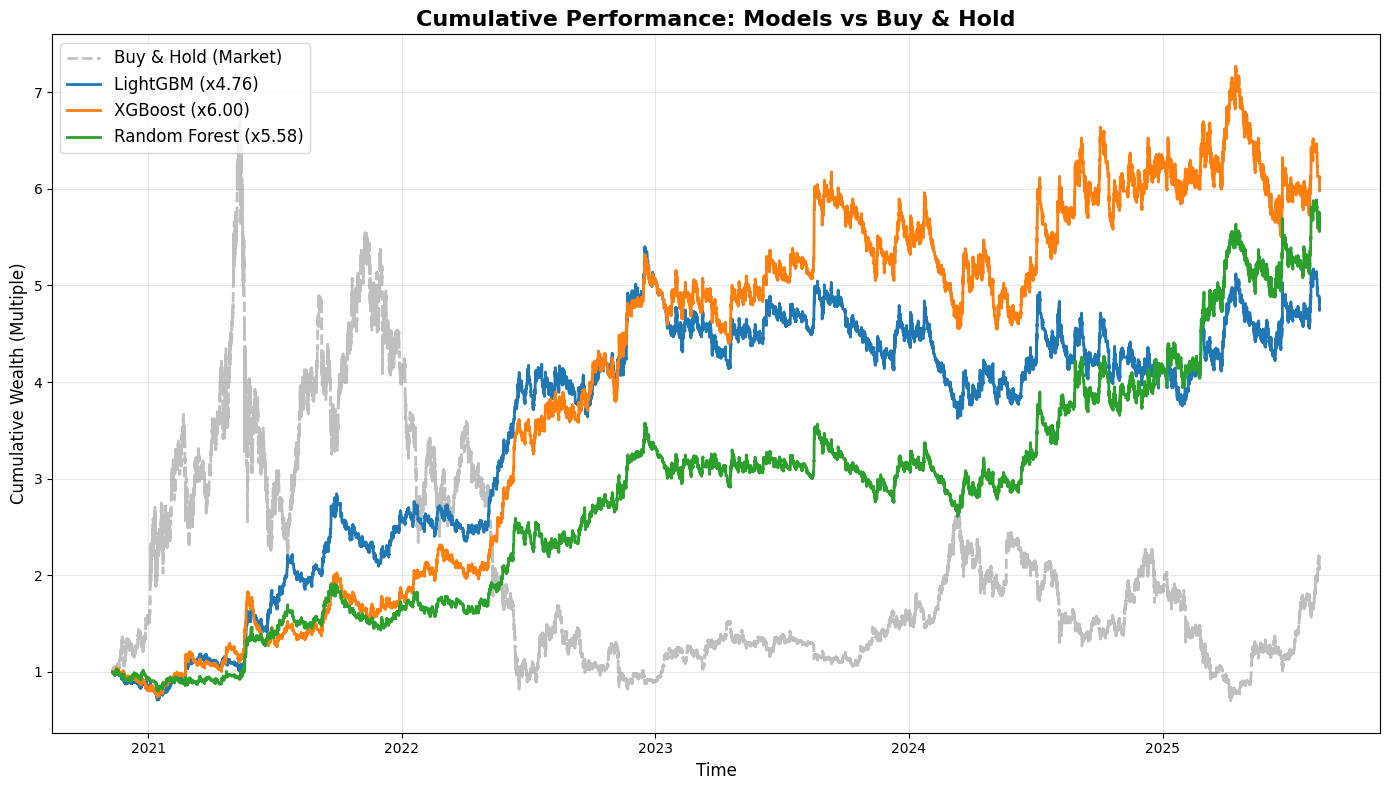

In [28]:
def plot_wealth_curve(fold_returns_store, market_returns_store, models):
    wealth_data = pd.DataFrame()

    full_market_ret = pd.concat(market_returns_store)
    wealth_data['Buy_Hold'] = (1 + full_market_ret).cumprod()

    for name in models.keys():
        full_model_ret = pd.concat(fold_returns_store[name])
        wealth_data[name] = (1 + full_model_ret).cumprod()

    wealth_data.index = full_market_ret.index

    plt.figure(figsize=(14, 8))

    plt.plot(wealth_data.index, wealth_data['Buy_Hold'],
             label='Buy & Hold (Market)', color='gray', alpha=0.5, linestyle='--', linewidth=2)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    for i, name in enumerate(models.keys()):
        if name in wealth_data.columns:
            final_val = wealth_data[name].iloc[-1]
            label_text = f"{name} (x{final_val:.2f})"
            plt.plot(wealth_data.index, wealth_data[name],
                     label=label_text, color=colors[i % len(colors)], linewidth=2)

    plt.title('Cumulative Performance: Models vs Buy & Hold', fontsize=16, fontweight='bold')
    plt.ylabel('Cumulative Wealth (Multiple)', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.legend(fontsize=12, loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
plot_wealth_curve(fold_returns_store, market_returns_store, models)

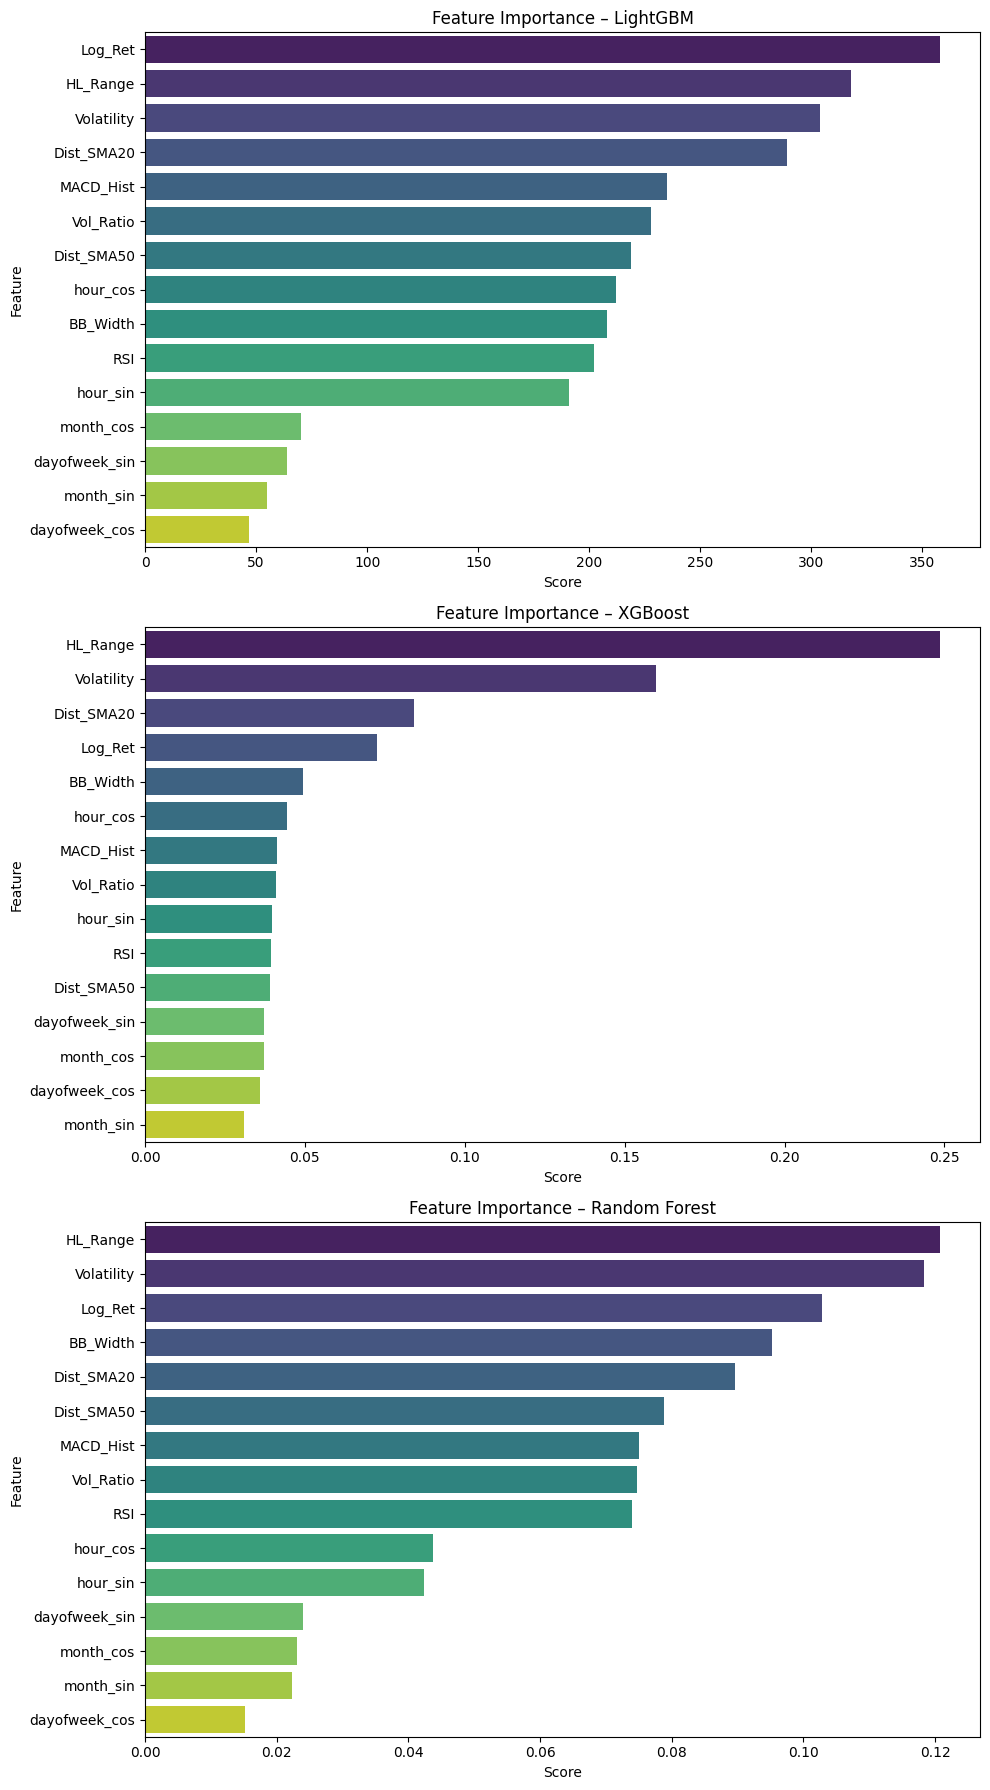

In [29]:
def plot_feature_importance(models, feature_names):
    valid_models = {k: v for k, v in models.items()}
    
    n_models = len(valid_models)
    fig, axes = plt.subplots(nrows=n_models, ncols=1, figsize=(10, 6 * n_models))
    
    
    for ax, (name, model) in zip(axes, valid_models.items()):
        importances = model.feature_importances_
        
        feature_imp = pd.DataFrame(sorted(zip(importances, feature_names)), columns=['Value','Feature'])
        
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False), ax=ax, palette="viridis")
        ax.set_title(f'Feature Importance – {name}')
        ax.set_xlabel('Score')
        
    plt.tight_layout()
    plt.show()

plot_feature_importance(models, feature_cols)

# Results

- Across five time-series cross-validation folds, all three models (LightGBM, XGBoost, and Random Forest) outperform the Buy & Hold strategy in terms of cumulative returns.

- Random Forest achieves the highest average Sharpe ratio (1.23), indicating more stable risk-adjusted performance. This suggests that the model is relatively effective at controlling risk and avoiding prolonged losing streaks, even though it does not deliver the highest absolute returns.

- XGBoost records the highest average return (50.87%), demonstrating a stronger ability to capture large market movements. However, this higher profitability comes at the cost of deeper drawdowns.

- LightGBM delivers moderate performance compared to the other two models. This indicates that its advantages in computational efficiency and optimization do not fully translate into superior trading performance in this particular setup.

- Although the win rate of all models is only around ~48%, the overall performance remains positive. This implies that the strategy does not rely on a high proportion of correct predictions, but instead benefits from an asymmetric payoff structure (larger gains versus smaller losses).



